In [1]:
# imports
import sys
sys.path.insert(1, 'C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites')
from imagequalitymetrics import ImageQualityMetrics
import SIREN
import matplotlib.pyplot as plt
import numpy as np
import imageio as io
import tensorflow as tf
import os
from numpy.random import default_rng
import normalize

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data_path = 'D:/jo77pihe/Registered/20220203_AutoQuant_Averaged'

In [4]:
# Randomly select 15 images
f = [f for f in os.listdir(data_path) if f.endswith('.tif')]

rng = default_rng(1234)
idx = rng.choice(len(f), size=15, replace=False)
idx_preproc =idx[0:5]
idx_train = idx[5:]
f_train = [f[i] for i in idx_train]
f_preproc = [f[i] for i in idx_preproc]
print(idx)
print(f_preproc)
print(f_train)

[222 227  32  61  24  75 189 127  87 214 226  58 190  28  39]
['Tim_2_NexCreERT2_2018-07-17_A2.tif', 'Tim_38_NexCreERT2_2018-08-22_D4.tif', 'Alessandro_520_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif', 'Ghabiba_341_Thy1GFP_2019-02-18_A1.tif', 'Alessandro_516_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A1.tif']
['Ghabiba_347_Thy1GFP_2019-02-18_A5.tif', 'Tim_178_ArcCre_2017-08-08_A2.tif', 'Tim_117_ArcCre_2017-05-08_A9.tif', 'Ghabiba_65_Thy1eGFP_2018-02-03_A1.tif', 'Tim_25_NexCreERT2_2018-07-10_A7.tif', 'Tim_38_NexCreERT2_2018-08-22_D3.tif', 'Ghabiba_335_Thy1GFP_2019-02-18_A5.tif', 'Tim_178_ArcCre_2017-08-08_A3.tif', 'Alessandro_516_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A5.tif', 'Alessandro_530_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-09-16_A2.tif']


## 0 Network architecture
*Which network architecture is suitable for representing our image stack sufficiently precise?*
* Perform grid search

In [5]:
n_layers = [1,2,3,4]
hidden_dims = [64,128,256]
steps = 1500
step_to_plot = 50
met = ImageQualityMetrics()
normalizer = normalize.PercentileNormalizer()

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0303
Epoch 2/10
1/1 [==============================] - 1s 704ms/step - loss: 0.4094
Epoch 3/10
1/1 [==============================] - 1s 719ms/step - loss: 0.0907
Epoch 4/10
1/1 [==============================] - 1s 688ms/step - loss: 0.0493
Epoch 5/10
1/1 [==============================] - 1s 696ms/step - loss: 0.0509
Epoch 6/10
1/1 [==============================] - 1s 734ms/step - loss: 0.0427
Epoch 7/10
1/1 [==============================] - 1s 688ms/step - loss: 0.0330
Epoch 8/10
1/1 [==============================] - 1s 766ms/step - loss: 0.0264
Epoch 9/10
1/1 [==============================] - 1s 660ms/step - loss: 0.0240
Epoch 10/10
1/1 [==============================] - 1s 765ms/step - loss: 0.0237


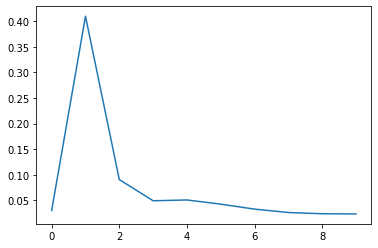

In [6]:
import time
i=0
f = 128
h = 1
args={}
args['hidden_layers'] = h
args['hidden_features']=f
plane_int = SIREN.application.InterplanePrediction(args)

stack = np.asarray(io.mimread(os.path.join(data_path, f_preproc[i])), dtype=np.float32)
gt, _ = plane_int.preprocess(stack, 1)
plane_int.train(gt,n_steps=steps, steps_to_plot=step_to_plot, batch_size=None)
prediction = plane_int.test(gt)

In [ ]:
for (idx,img) in enumerate(f_preproc):
    stack = np.asarray(io.mimread(os.path.join(data_path, img)), dtype=np.float32)

    res_psnr = np.zeros((len(n_layers), len(hidden_dims)))
    res_ssim = np.zeros((len(n_layers), len(hidden_dims)))
    labs = []
    for (nx, nl) in enumerate(n_layers):
        for (hx, hd) in enumerate(hidden_dims):
            args={}
            args['hidden_layers'] = nl
            args['hidden_features']=hd
            plane_int = SIREN.application.InterplanePrediction(args)
            X, _ = plane_int.preprocess(stack, 1)

            loss = plane_int.train(X,n_steps=steps, steps_to_plot=step_to_plot, batch_size=None)
            prediction = plane_int.test(X)
            tif.imwrite(str(nl)+'_'+str(hd)+'_'+img, prediction)
            
            # Evaluation
            stack -= stack.min()  # * 2 - 1
            stack = stack / stack.max()
            
            res_psnr[nx,hx] = met.psnr(prediction, stack)
            res_ssim[nx,hx] = met.ssim(prediction, stack)
            np.save('res_psnr', res_psnr)
            np.save('res_ssim', res_ssim)
            labs.append('Layers: ' + str(nl)+', Hidden_dim: '+ str(hd))
            print(str(nl), str(hd))

In [ ]:
plt.figure()
l = []
s = np.arange(0, steps+2, 50)
i = 0
for (nx, nl) in enumerate(n_layers):
    for (hx, hd) in enumerate(hidden_dims): 
        if res_psnr[nx,hx,5] !=0:
            plt.plot(s, res_psnr[nx,hx,:])
            l.append(labs[i])
        i +=1
        
plt.grid()
plt.legend(l,bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Steps')
plt.ylabel('PSNR')

In [ ]:
plt.figure()
s = np.arange(0, steps+2, 50)
i = 0

for (nx, nl) in enumerate(n_layers):
    for (hx, hd) in enumerate(hidden_dims): 
        if res_psnr[nx,hx,5] !=0:
            plt.plot(s, res_ssim[nx,hx,:])
            l.append(labs[i])
        i +=1        
plt.grid()
plt.legend(l, bbox_to_anchor=(1.1, 1.05))
plt.xlabel('Steps')
plt.ylabel('SSIM')